In [1]:
import torchvision
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

print(device)

cuda:0


In [3]:
print(torch.cuda.get_device_name())
print(torch.__version__)
print(torch.version.cuda)
x = torch.randn(1).cuda()
print(x)

NVIDIA GeForce RTX 3050 Ti Laptop GPU
2.4.0+cu124
12.4
tensor([-0.1081], device='cuda:0')


In [15]:
torch.manual_seed(17)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)

val_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)

In [16]:
pretrained_net = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)

In [17]:
pretrained_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
finetuned_net = nn.Sequential(
    pretrained_net,
    nn.ReLU(),
    nn.Linear(1000, 2),
)

In [19]:
import time
import copy

train_losses = []
val_losses = []

def train_model(
    model, dataloaders, criterion, optimizer, num_epochs=25
):
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)


            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)


        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [20]:
import os

data_dir = "images_by_side"
batch_size = 32

model_ft = finetuned_net.to(device)
train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "train"), transform=train_augs
    ),
    batch_size=batch_size,
    shuffle=True,
)
val_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "val"), transform=val_augs
    ),
    shuffle=True,
    batch_size=batch_size,
)
loss = nn.CrossEntropyLoss(reduction="none")

In [21]:
def train_fine_tuning(net, learning_rate, num_epochs=30):

    trainer = torch.optim.SGD([{"params": finetuned_net[2].parameters(), "lr": learning_rate*10}], lr=learning_rate)

    dataloaders_dict = {"train": train_iter, "val": val_iter}
    criterion = nn.CrossEntropyLoss()
    model_ft, hist = train_model(
        net, dataloaders_dict, criterion, trainer, num_epochs=num_epochs
    )
    return model_ft, hist


In [22]:
import numpy as np

In [23]:
model_ft, hist = train_fine_tuning(model_ft, learning_rate=2e-4)

Epoch 1/30
----------
train Loss: 0.6095 Acc: 0.6501
val Loss: 0.6004 Acc: 0.6410

Epoch 2/30
----------
train Loss: 0.4895 Acc: 0.7698
val Loss: 0.4888 Acc: 0.7949

Epoch 3/30
----------
train Loss: 0.4249 Acc: 0.8306
val Loss: 0.4683 Acc: 0.8205

Epoch 4/30
----------
train Loss: 0.4108 Acc: 0.8103
val Loss: 0.3466 Acc: 0.8547

Epoch 5/30
----------
train Loss: 0.3713 Acc: 0.8471
val Loss: 0.2682 Acc: 0.9060

Epoch 6/30
----------
train Loss: 0.3708 Acc: 0.8398
val Loss: 0.2277 Acc: 0.9316

Epoch 7/30
----------
train Loss: 0.3687 Acc: 0.8471
val Loss: 0.2132 Acc: 0.9487

Epoch 8/30
----------
train Loss: 0.3434 Acc: 0.8435
val Loss: 0.2100 Acc: 0.9316

Epoch 9/30
----------
train Loss: 0.3479 Acc: 0.8269
val Loss: 0.2059 Acc: 0.9231

Epoch 10/30
----------


KeyboardInterrupt: 

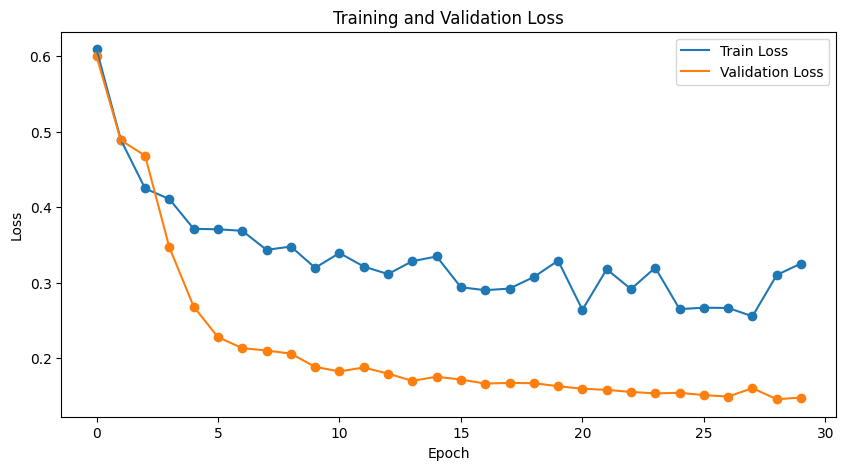

In [147]:
starting_epoch = 0
y = list(range(starting_epoch, len(train_losses)))
plt.figure(figsize=(10, 5))
plt.plot(y, train_losses[starting_epoch:], label='Train Loss')
plt.scatter(y, train_losses[starting_epoch:])
plt.plot(y, val_losses[starting_epoch:], label='Validation Loss')
plt.scatter(y, val_losses[starting_epoch:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [148]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [149]:
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')

    image = transform(image).unsqueeze(0)

    image = image.to(device)

    model.eval()

    with torch.no_grad():
        output = model(image)

    _, predicted = torch.max(output, 1)

    return predicted.item(), image.cpu().squeeze()

def visualize_prediction(image_path, model, transform, class_names):
    predicted_class, image_tensor = predict_image(image_path, model, transform)
    # plt.figure(figsize=(6, 6))
    # imshow(image_tensor, title=f'Predicted: {class_names[predicted_class]}')
    # plt.show()
    return class_names[predicted_class]

def visualize_predictionWithImage(image_path, model, transform, class_names):
    predicted_class, image_tensor = predict_image(image_path, model, transform)
    plt.figure(figsize=(6, 6))
    imshow(image_tensor, title=f'Predicted: {class_names[predicted_class]}')
    plt.show()
    return class_names[predicted_class]

image_path = 'images_by_side/train/right/13c2ur549vohc0jat2dvu3xrxb1_27.png'

class_names = ["left", "right"]



131aedfhs6pnf1fvtvp49mff2pm7g60u22_48.png


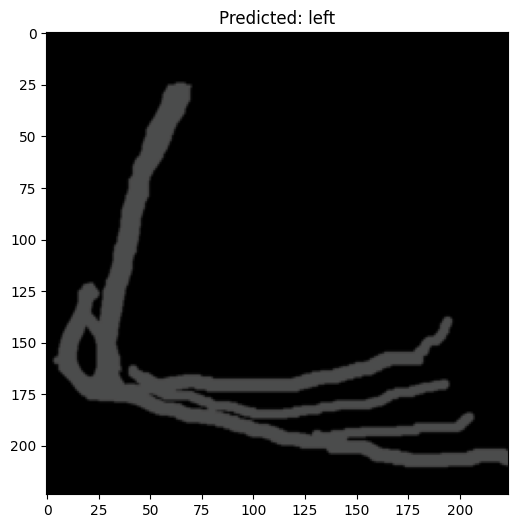

131aedfhs6pnf1fvtvp49mg8hvypp6vo22_21.png


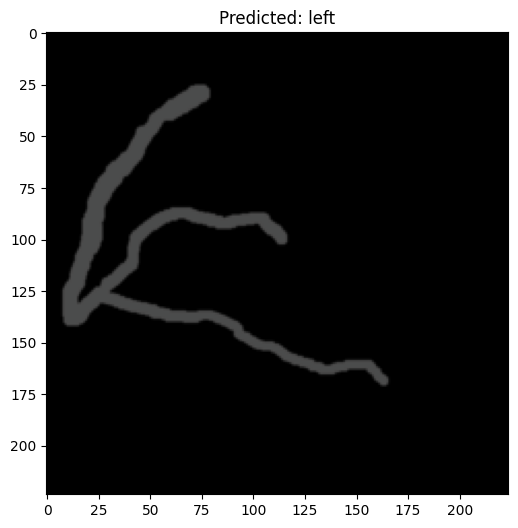

131aedfhs6pnf1fvtvp49mg8hvyy093222_31.png


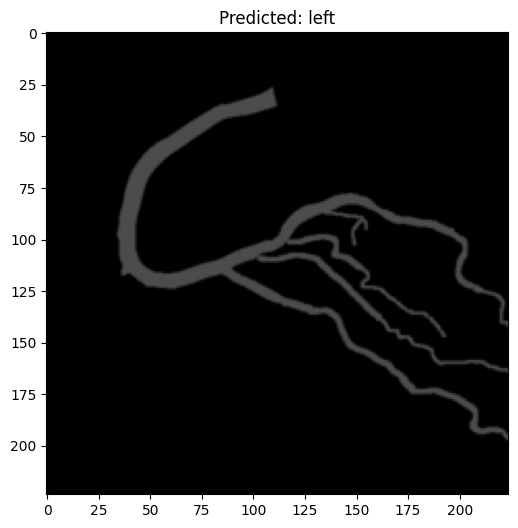

131aedfhs6pnf1fvtvp49mj5g3q7xsrn22_31.png


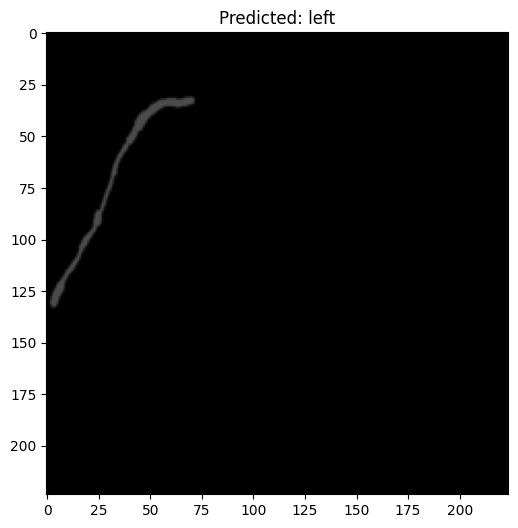

131aedfhs6pnf1fvtvp49mja0v3tgkmz22_30.png


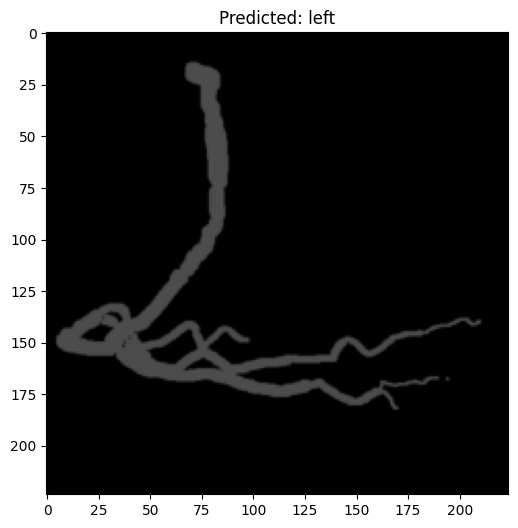

131aedfhs6pnf1fvtvp49mjf02qnmxg322_45.png


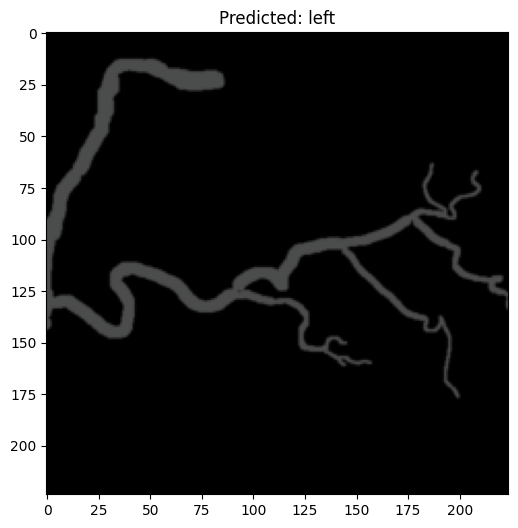

131aedfhs6pnf1fvtvp49mldx9emed2q22_45.png


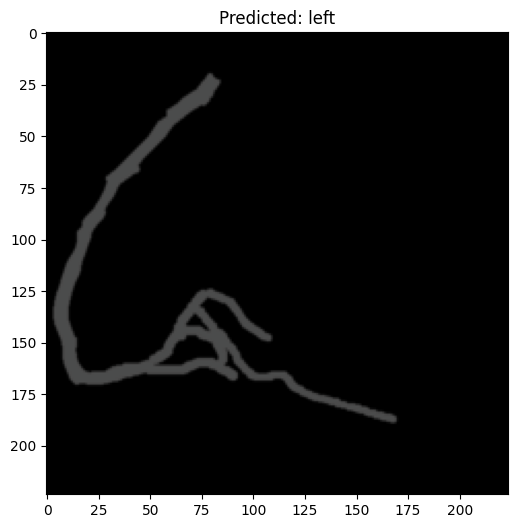

In [150]:
import os

directory_path = 'images_by_side/test/right'

file_names = os.listdir(directory_path)

file_names = [f for f in file_names if os.path.isfile(os.path.join(directory_path, f))]

class_names = ["left", "right"]
# print(file_names)
for file_name in file_names:
    image_path = os.path.join(directory_path, file_name)
    predicted_class = visualize_prediction(image_path, model_ft, val_augs, class_names)
    if predicted_class == "left":
        print(file_name)
        visualize_predictionWithImage(image_path, model_ft, val_augs, class_names)


In [136]:
print(len(file_names))

50


In [1]:
import sys
print(sys.version)

3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
